In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

# General stats
Avg number of steps, std...

In [22]:
mat = pd.read_csv("datasets/heatmap_2_twolevels.csv",header=None).to_numpy()

In [23]:
solved_at = (mat==0).argmax(axis=1)
solved_at[solved_at==0] = mat.shape[1]

In [24]:
print(f'mean: {solved_at.mean()}, std: {solved_at.std()}, max: {solved_at.max()}')

mean: 17.3, std: 8.54848914526226, max: 28


In [25]:
df = pd.read_csv('./datasets/steps.csv')
df = df.loc[df['tangram nr' ] ==4]

print(df['grid_val'].unique())
df = df[['sid','tangram nr','step']]
participants = df.groupby(['sid','tangram nr']).max()['step'].to_numpy()
participants = participants[participants<30]
participants

[11. 23.  2. 13.  8.  9.  7. 12.  3. 10. 14. 18. 19. 24.]


array([15, 25,  7,  7,  8, 15,  8, 22,  7,  7,  7,  9, 12, 10, 20,  9, 10,
        7, 24,  7, 12,  9, 12, 20, 19, 12,  9,  9, 21], dtype=int64)

In [26]:
print(f'mean: {participants.mean()}, std: {participants.std()}, max: {participants.max()}')

mean: 12.379310344827585, std: 5.707912192154086, max: 25


# Heatmaps

In [27]:
heatmap = np.zeros((5,10))
for i in range(5):
    p = i+1
    for m in range(10):
        heatmap[i,m] = np.count_nonzero(mat[:,m] == p)


In [28]:
heatmap = heatmap/heatmap.sum(axis=0,keepdims=1)

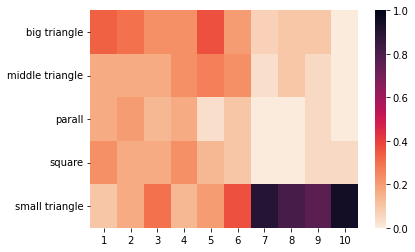

In [29]:
cmap = sns.cm.rocket_r
y_axis_labels = ['small triangle','square','parall','middle triangle','big triangle']
x_axis_labels = [1,2,3,4,5,6,7,8,9,10]
fig, ax = plt.subplots()
sns.heatmap(heatmap,ax=ax,yticklabels=y_axis_labels,xticklabels=x_axis_labels,cmap=cmap,vmin=0, vmax=1)
ax.invert_yaxis()
plt.show()


# Sequence evaluation

Tangram 4

In [12]:
users = pd.read_csv('datasets/train_states.csv')
users = users.loc[users['tangram nr'] ==2]
model = pd.read_csv('datasets/model_states_evolution_2_large.csv')

## Method1: step-by-step matching

For each run, the model gets its score by comparing the position at each step with user data at step +-1, scoring 1 point if there is any match

In [13]:
score = 0
max_score = 0
for run in model.run.unique():
    run_steps = model.loc[model.run == run]
    for step in range(3,12):
        
        state = run_steps.iloc[step][['small triangle','middle triangle','big triangle','square','parallelogram']]
        previous = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        last_state = run_steps.iloc[-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        if not (state.equals(last_state) and state.equals(previous)):
            max_score +=1
            users_at_step = users.loc[users['step'].isin([step-1,step,step+1])][['small triangle','middle triangle','big triangle','square','parallelogram']]
            res= users_at_step.loc[
                (users_at_step['small triangle'] == state['small triangle']) &
                (users_at_step['middle triangle'] == state['middle triangle']) &
                (users_at_step['big triangle'] == state['big triangle']) &
                (users_at_step['square'] == state['square']) &
                (users_at_step['parallelogram'] == state['parallelogram'])
            ]
            if not res.empty:
                score+=1
print(score)
print(max_score)
print(score/max_score)

75
171
0.43859649122807015


In [179]:
users[['small triangle','middle triangle','big triangle','square','parallelogram']].head(20)

,small triangle,middle triangle,big triangle,square,parallelogram
48,set(),set(),set(),set(),"{(11.0, 90.0)}"
49,"{(23.0, 0.0)}",set(),set(),set(),"{(11.0, 90.0)}"
50,"{(23.0, 0.0)}",set(),set(),"{(23.0, 0.0)}","{(11.0, 90.0)}"
51,"{(23.0, 0.0), (2.0, 135.0)}",set(),set(),"{(23.0, 0.0)}","{(11.0, 90.0)}"
52,"{(23.0, 0.0), (2.0, 135.0)}",set(),"{(13.0, 270.0)}","{(23.0, 0.0)}","{(11.0, 90.0)}"
53,"{(23.0, 0.0), (2.0, 135.0)}",set(),"{(13.0, 270.0), (8.0, 135.0)}","{(23.0, 0.0)}","{(11.0, 90.0)}"
54,"{(23.0, 0.0), (2.0, 135.0)}",set(),"{(13.0, 270.0), (8.0, 135.0)}","{(23.0, 0.0)}","{(11.0, 90.0)}"
55,"{(23.0, 0.0), (2.0, 135.0)}",set(),"{(7.0, 45.0)}","{(23.0, 0.0)}",set()
56,"{(23.0, 0.0), (2.0, 135.0)}",set(),"{(7.0, 45.0)}","{(23.0, 0.0)}","{(11.0, 90.0)}"
57,"{(23.0, 0.0), (2.0, 135.0)}","{(7.0, 225.0)}","{(7.0, 45.0)}","{(23.0, 0.0)}","{(11.0, 90.0)}"


In [167]:
model.loc[model.run==3]

,Unnamed: 0,run,step,small triangle,middle triangle,big triangle,square,parallelogram
52,52,3,1,"{(2.0, 135.0)}",set(),set(),set(),set()
53,53,3,2,"{(2.0, 135.0)}",set(),"{(13.0, 270.0)}",set(),set()
54,54,3,3,"{(2.0, 135.0)}",set(),"{(7.0, 90.0), (13.0, 270.0)}",set(),set()
55,55,3,4,"{(2.0, 135.0)}",set(),"{(13.0, 270.0)}",set(),"{(11.0, 90.0)}"
56,56,3,5,"{(2.0, 135.0)}",set(),"{(13.0, 270.0)}","{(23.0, 0.0)}","{(11.0, 90.0)}"
57,57,3,6,"{(23.0, 0.0), (2.0, 135.0)}",set(),"{(13.0, 270.0)}","{(23.0, 0.0)}","{(11.0, 90.0)}"
58,58,3,7,"{(23.0, 0.0), (2.0, 135.0)}","{(8.0, 225.0)}","{(13.0, 270.0)}","{(23.0, 0.0)}","{(11.0, 90.0)}"
59,59,3,8,"{(23.0, 0.0), (2.0, 135.0)}",set(),"{(7.0, 90.0), (13.0, 270.0)}","{(23.0, 0.0)}","{(11.0, 90.0)}"
60,60,3,9,"{(23.0, 0.0), (2.0, 135.0)}","{(12.0, 270.0)}",set(),"{(23.0, 0.0)}","{(11.0, 90.0)}"
61,61,3,10,"{(23.0, 0.0), (2.0, 135.0)}",set(),set(),"{(23.0, 0.0)}","{(11.0, 90.0)}"


## Method1: rms

In [166]:
def state_diff(model,user):
    diff = 0
    for c in ['small triangle','middle triangle','big triangle','square','parallelogram']:
        if user[c] != model[c]:
            diff +=1
    return diff



errors = 10*np.ones((len(model.run.unique()),13))
for run in model.run.unique():
    run_steps = model.loc[model.run == run]
    for step in range(3,16):
        
        state = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        previous = run_steps.iloc[step-2][['small triangle','middle triangle','big triangle','square','parallelogram']]
        last_state = run_steps.iloc[-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        if not (state.equals(last_state) and state.equals(previous)):
            max_score +=1
            users_at_step = users.loc[users['step']==step][['small triangle','middle triangle','big triangle','square','parallelogram']]
            res = users_at_step.apply(lambda x: state_diff(state,x),axis=1)
            rmse = np.sqrt(np.mean((res)**2))
            errors[run,step-3] = rmse
#             res= users_at_step.loc[
#                 (users_at_step['small triangle'] == state['small triangle']) &
#                 (users_at_step['middle triangle'] == state['middle triangle']) &
#                 (users_at_step['big triangle'] == state['big triangle']) &
#                 (users_at_step['square'] == state['square']) &
#                 (users_at_step['parallelogram'] == state['parallelogram'])
#             ]


errors.min(axis=0)

array([2.29492193, 2.40138849, 2.20605228, 2.18326972, 2.34520788,
       2.20605228, 2.30940108, 2.10554823, 1.97484177, 2.25831796,
       2.20605228, 2.04939015, 2.01659779])

In [160]:
def state_diff(model,user):
    diff = 0
    for c in ['small triangle','middle triangle','big triangle','square','parallelogram']:
        if user[c] != model[c]:
            diff +=1
    return diff


score = 0
max_score = 0
errors = 10*np.ones((len(model.run.unique()),13))
for run in model.run.unique():
    run_steps = model.loc[model.run == run]
    for step in range(3,16):
        
        state = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        previous = run_steps.iloc[step-2][['small triangle','middle triangle','big triangle','square','parallelogram']]
        last_state = run_steps.iloc[-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        if not (state.equals(last_state) and state.equals(previous)):
            max_score +=1
            users_at_step = users.loc[users['step']==step][['small triangle','middle triangle','big triangle','square','parallelogram']]
            res = users_at_step.apply(lambda x: state_diff(state,x),axis=1)
            errors[run,step-3] = min(res)
            if not res.empty:
                score+=1
print(score)
print(max_score)
 
print(score/max_score)

errors

305
305
1.0


array([[ 0.,  1.,  0.,  1.,  0.,  0., 10., 10., 10., 10., 10., 10., 10.],
       [ 1.,  1.,  1.,  2.,  2.,  2.,  1.,  2.,  1.,  0.,  0., 10., 10.],
       [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  2.,  2.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  0.,  1.,  1.,  2.,  1.,  1.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  0., 10.],
       [ 1.,  2.,  0.,  1.,  0.,  0., 10., 10., 10., 10., 10., 10., 10.],
       [ 0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  2.,  2.,  1.],
       [ 1.,  2.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.],
       [ 1.,  1.,  1.,  2.,  2.,  1.,  2.,  2.,  2.,  1.,  0., 10., 10.],
       [ 2.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  0., 10., 10., 10.],
       [ 1.,  0.,  1.,  2.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.],
       [ 1.,  1.,  1.,  0.,  1.,  1., 

In [74]:
step=3
users_at_step = users.loc[users['step']==step][['small triangle','middle triangle','big triangle','square','parallelogram']]
run_steps=  model.loc[model.run == 1]
state = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]



## Method2: phase-by-phase matching

For each run, the results is matched at step 4, 8 and 12, getting incremental points if such sequence also appears in participants data, some margin or error is accepted

In [72]:
score=0
same_seq= 0
for run in model.run.unique():

    run_steps = model.loc[model.run == run]
    
    #step 4
    step=4
    model_at_step = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
    users_at_step = users.loc[users['step'].isin(range(step-1,step+2))]
    res= users_at_step.loc[
                (users_at_step['small triangle'] == model_at_step['small triangle']) &
                (users_at_step['middle triangle'] == model_at_step['middle triangle']) &
                (users_at_step['big triangle'] == model_at_step['big triangle']) &
                (users_at_step['square'] == model_at_step['square']) &
                (users_at_step['parallelogram'] == model_at_step['parallelogram'])
            ]
    if res.empty:
        
        continue
    
    score +=1
    filtered=  users.loc[users['sid'].isin(res.sid.unique())]
    
    #step 8
    step = 8
    model_at_step = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
    users_at_step = users.loc[users['step'].isin(range(step-2,step+3))]
    res= users_at_step.loc[
                (users_at_step['small triangle'] == model_at_step['small triangle']) &
                (users_at_step['middle triangle'] == model_at_step['middle triangle']) &
                (users_at_step['big triangle'] == model_at_step['big triangle']) &
                (users_at_step['square'] == model_at_step['square']) &
                (users_at_step['parallelogram'] == model_at_step['parallelogram'])
            ]
    if res.empty:
        
        continue
    
    score +=2
    filtered=  users.loc[users['sid'].isin(res.sid.unique())]
    
#     step 8
    step = 12
    model_at_step = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
    users_at_step = users.loc[users['step'].isin(range(step-3,step+4))]
    res= users_at_step.loc[
                (users_at_step['small triangle'] == model_at_step['small triangle']) &
                (users_at_step['middle triangle'] == model_at_step['middle triangle']) &
                (users_at_step['big triangle'] == model_at_step['big triangle']) &
                (users_at_step['square'] == model_at_step['square']) &
                (users_at_step['parallelogram'] == model_at_step['parallelogram'])
            ]
    if res.empty:
        
        continue
    
    score +=3
    same_seq +=1
    filtered=  users.loc[users['sid'].isin(res.sid.unique())]

print(score)
print(same_seq)

16
2
